In [19]:
import numpy as np
import datetime as dt
from scipy import signal
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from load_data import * 
import numbers

In [14]:
dvolc_source = np.genfromtxt('volc_source_850_1850.csv', delimiter=",", dtype=float).flatten()
dvolc_years = np.genfromtxt('sigl_years.txt', delimiter=",", dtype=float).flatten()
dvolc_gvf = np.genfromtxt('sigl_gvf.txt', delimiter=",", dtype=float).flatten()
dvolc_source = np.genfromtxt('sigl_source.txt', delimiter=",", dtype=float).flatten()
dvolc = np.genfromtxt('sigl.txt', delimiter=",", dtype=float).flatten()
delphi_null = delphi_null.flatten()
delphi_hist_null = delphi_null
delphi_inst = np.genfromtxt('delphi_inst.txt', delimiter=",", dtype=float)
ismr_phi_inst = np.genfromtxt('ismr_phi_inst.txt', delimiter=",", dtype=float)
nino_phi_inst = np.genfromtxt('nino3_phi_inst.txt', delimiter=",", dtype=float)

delphi_hist = np.genfromtxt('delphi.csv', delimiter=",", dtype=float).flatten()
nino_phi = np.genfromtxt('nino_phi.csv', delimiter=",", dtype=float).flatten()
ismr_phi = np.genfromtxt('ismr_phi.csv', delimiter=",", dtype=float).flatten()

delphi_hist_grad = np.gradient(delphi_hist)
nino_phi_grad = np.gradient(nino_phi)
ismr_phi_grad = np.gradient(ismr_phi)

nino_hist_grad = nino_phi_grad
ismr_hist_grad = ismr_phi_grad

# Bootstrapping d phi / dt after volcanic eruptions
nino_hist_grad_volc = []
nino_hist_grad_novolc = []
ismr_hist_grad_volc = []
ismr_hist_grad_novolc = []

i = 0
win = 8
while i < delphi_hist_grad.shape[0]-win*12:
    yy = int(i/12)
    if np.abs(dvolc[yy]) > 1.0:
        nino_hist_grad_volc.append(nino_hist_grad[i:i+win*12])
        ismr_hist_grad_volc.append(ismr_hist_grad[i:i+win*12])
        i = i+win*12
        continue
    else:
        nino_hist_grad_novolc.append(nino_hist_grad[i])
        ismr_hist_grad_novolc.append(ismr_hist_grad[i])
        i = i + 1
#print(dvolc.shape[0])

In [24]:
def abline(slope, intercept, axes):
    """Plot a line from slope and intercept"""
    #axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, color='k')
    
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False, rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.
    Parameters
    ----------
    x, y : array-like
    One-dimensional numeric arrays.
    ax : matplotlib.axes.Axes, optional
    Axes on which to plot. If not provided, the current axes will be used.
    quantiles : int or array-like, optional
    Quantiles to include in the plot. This can be an array of quantiles, in
    which case only the specified quantiles of `x` and `y` will be plotted.
    If this is an int `n`, then the quantiles will be `n` evenly spaced
    points between 0 and 1. If this is None, then `min(len(x), len(y))`
    evenly spaced quantiles between 0 and 1 will be computed.
    interpolation : {linear, lower, higher, midpoint, nearest}
    Specify the interpolation method used to find quantiles when `quantiles`
    is an int or None. See the documentation for numpy.quantile().
    rug : bool, optional
    If True, draw a rug plot representing both samples on the horizontal and
    vertical axes. If False, no rug plot is drawn.
    rug_length : float in [0, 1], optional
    Specifies the length of the rug plot lines as a fraction of the total
    vertical or horizontal length.
    rug_kwargs : dict of keyword arguments
    Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
    matplotlib.axes.Axes.axhline() when drawing rug plots.
    kwargs : dict of keyword arguments
    Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
    the q-q plot.
    """
# Get current axes if none are provided
    if ax is None:
        ax = plt.gca()
    if quantiles is None:
        quantiles = min(len(x), len(y))
# Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)
# Draw the rug plots if requested
    if rug:
# Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)
# Override default setting by any user-specified settings
    if rug_kwargs is not None:
        rug_x_params.update(rug_kwargs)
        rug_y_params.update(rug_kwargs)
# Draw the rug plots
    #for point in x:
    #    ax.axvline(point, **rug_x_params)
    #for point in y:
    #    ax.axhline(point, **rug_y_params)
# Draw the q-q plot

    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.set_xlabel('ENSO phase speed (NoVolc)')
    ax.set_ylabel('ENSO phase speed (Volc)')
    ax.set_title('Q-Q plot of ENSO phase speed')
    abline(1,0, ax)


In [4]:
def polar_plot(ax, phi, l_):
    #delphi_inst = np.genfromtxt('delphi_inst.txt', delimiter=",", dtype=float)
    
    #phi = delphi_inst
    # get histogram
    hc, be = np.histogram(phi, bins='sturges')
    bc = 0.5 * (be[1:] + be[:-1])

    values, bins = ax.hist(phi, bins='sturges', label=l_,  alpha=0.5, range=(0,1), normed=True)
    off = 0.10 * (hc.max() - hc.min())
    ax.set_rorigin(-off)
    ax.grid("on")
    xmajloc = MaxNLocator(nbins=4, integer=True, prune="upper")
    ax.yaxis.set_major_locator(xmajloc)
    ax.set_rlabel_position(0)
    ax.set_frame_on(False)
    ax.set_xticklabels([
                         "0",
                         r"$\dfrac{\pi}{4}$",
                         r"$\dfrac{\pi}{2}$",
                         r"$\dfrac{3\pi}{4}$",
                         r"$\pi$",
                         r"$\dfrac{5\pi}{4}$",
                         r"$\dfrac{3\pi}{2}$",
                         r"$\dfrac{7\pi}{4}$",
                         # r"$2\pi$",
                         ])
    return values, bins

/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/manmeet/anaconda3/envs/py35/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
No handles with labels found to put in legend.


bins =  [0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.        ]


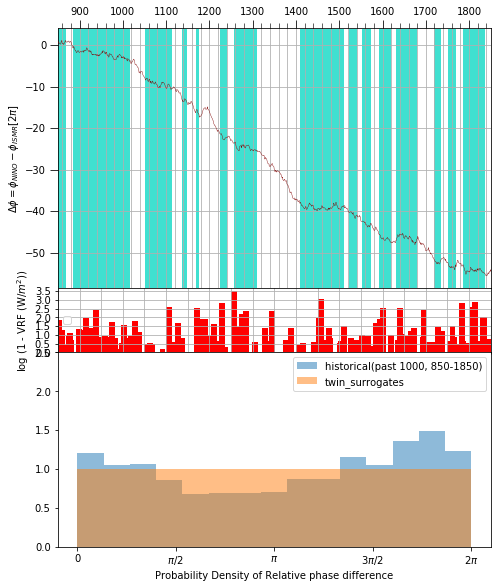

In [5]:
def delphi_timeseries(ct, del_phi, te, volc_time, dvolc_source, dvolc_gvf,  
                     delphi_hist_dist_2, delphi_hist_null_dist_2, delphi_inst, delphi_inst_dist_2,
                     delphi_null_inst_dist_2, it, te_inst, nino_phi_grad, ismr_phi_grad):
    """
    Plots the instantaneous phase diff with periods of phase sync highlighted.
    """
    # set up figure
    fig = pl.figure(figsize=[7.08, 9.0])
    axlabfs, tiklabfs, splabfs = 4, 4, 4
    start_year = 850
    end_year = 1850

    # set up ax1 and plot delPhi and event series there
    ax1 = fig.add_axes([0.1, 0.57, 0.85, 0.4])
    ax1.plot(ct, -del_phi/6.28,
             c="Maroon", zorder=5, linewidth=0.4
             )
    ax1.plot(it, -delphi_inst/6.28,
             c="Maroon", zorder=5, linewidth=0.4
             )
    ylo, yhi = ax1.get_ylim()
    ax1.bar(te,
            width = 200 * np.ones(len(te)),
            height = (yhi - ylo) * np.ones(len(te)),
            bottom = ylo * np.ones(len(te)),
            edgecolor="none", facecolor="Turquoise",
            zorder=1,)
    ax1.bar(te_inst,
            width = 200 * np.ones(len(te_inst)),
            height = (yhi - ylo) * np.ones(len(te_inst)),
            bottom = ylo * np.ones(len(te_inst)),
            edgecolor="none", facecolor="Turquoise",
            zorder=1,)
    # set up second ax2 and plot the volcanic radiative forcing 
    ax2 = fig.add_axes([0.1, 0.47, 0.85, 0.1])
    ax3 = fig.add_axes([0.1, 0.17, 0.85, 0.3])
    #ax4 = fig.add_axes([0.525, 0.13, 0.425, 0.3])
    
    vtime = volc_time[dvolc_source==1]
    dvolc_tropical = dvolc_gvf[dvolc_source==1]
    #ax2.bar(vtime, dvolc_tropical, color='r', width=250)
    ax2.bar(vtime, np.log(1-dvolc_tropical), color='r', width=5000)

    
    vtime = volc_time[dvolc_source==2]
    dvolc_nh = dvolc_gvf[dvolc_source==2]
    #ax2.bar(vtime, dvolc_nh, color='r', width=250)
    ax2.bar(vtime, np.log(1-dvolc_nh), color='r', width=5000)

    vtime = volc_time[dvolc_source==3]
    dvolc_sh = dvolc_gvf[dvolc_source==3]
    #ax2.bar(vtime, dvolc_sh, color='r', width=250)
    ax2.bar(vtime, np.log(1-dvolc_sh), color='r', width=5000)
    ax2.set_xlim([ct[0], 5])
    #ax2.set_ylim([-10, 0])
    
    values_hist, bins_hist, _ = ax3.hist(delphi_hist_dist_2, normed=True, bins='sturges', alpha=0.5, label='historical(past 1000, 850-1850)', range=(0,1))
    values_hist_null, bins_hist_null, _ = ax3.hist(delphi_hist_null_dist_2, normed=True, bins=bins_hist, alpha=0.5, label='twin_surrogates', range=(0,1))
    #print("bins = ", bins_hist)

    #values_hist, bins_hist, _ = ax3.hist(delphi_inst_dist_2, bins='sturges',normed=True, alpha=0.5, label='instrumental era (1871-present)')#, range=(0,1))
    #values_hist_null, bins_hist_null, _ = ax3.hist(delphi_null_inst_dist_2,normed=True,  bins=bins_hist, alpha=0.5, label='twin_surrogates')#, range=(0,1))
    #ax3.set_xticklabels([
    #                     "0",
    #                     r"$\dfrac{\pi}{4}$",
    #                     r"$\dfrac{\pi}{2}$",
    #                     r"$\dfrac{3\pi}{4}$",
    #                     r"$\pi$",
    #                     r"$\dfrac{5\pi}{4}$",
    #                     r"$\dfrac{3\pi}{2}$",
    #                     r"$\dfrac{7\pi}{4}$",
    #                      r"$2\pi$",
    #                     ])
    print("bins = ", bins_hist)
    for ax in [ax3]:
        ax.set_xlabel('Probability Density of Relative phase difference')
        ax.legend()
        ax.set_xticks(np.arange(0, 1.1, step=0.25))
        ax.set_xticklabels(['0','$\pi$/2','$\pi$','3$\pi$/2','2$\pi$'])
        ax.set_ylim([0, 2.5])
    #ax3.set_ylabel('Probability Density')
    
    #ax4.yaxis.tick_right()
    #ax4.set_ylabel('Probability Density')
    #ax4.yaxis.label_right()
        
    ax2.legend(loc='center left',  prop={'size': 10})
    
    ylo, yhi = ax1.get_ylim()
    xlo, xhi = dt.datetime(start_year, 1, 1), dt.datetime(end_year, 12, 31)
    ax1.set_xlim(xlo, xhi)
    XMajorLocator = mdates.YearLocator(base=100, month=6, day=15)
    XMinorLocator = mdates.YearLocator(base=20, month=6, day=15)
#    XMajorLocator = mdates.YearLocator(base=20, month=6, day=15)
#    XMinorLocator = mdates.YearLocator(base=5, month=6, day=15)

    XMajorFormatter = mdates.DateFormatter("%Y")
    ax1.xaxis.set_major_locator(XMajorLocator)
    ax1.xaxis.set_minor_locator(XMinorLocator)
    ax1.xaxis.set_major_formatter(XMajorFormatter)
    #ax1.set_ylim(ylo, 1900)
    #ax1.set_ylim(ylo, 1900)
    ax1.set_ylim(ylo, 4)
    #ax1.set_ylim(-12, 4)
    ax1.xaxis.tick_top()
    
    #ax1.set_xticklabels([]) 
    #ax1.set_ylim(-12,12 )
    ax1.grid(which="both")
    ax1.tick_params(which="major", size=8, direction="out")
    ax1.tick_params(which="minor", size=5, direction="out")
    ax1.tick_params(axis="both", labelsize=tiklabfs)
#    ax1.set_xlabel("Time", fontsize=axlabfs)
    ax1.set_ylabel(r"$\Delta\phi = \phi_{NINO} - \phi_{ISMR}[2\pi]$")
    #pl.rcParams.update({'font.size': 12})
#   ax1.set_ylabel(r"$\Delta\phi = \phi_{ISMR} - \phi_{NINO}[2\pi]$",
    #ax1.set_ylabel("Phase Locking Value \n (PLV)", fontsize=axlabfs)


    # prettify ax2
    xlo, xhi = dt.datetime(start_year, 1, 1), dt.datetime(end_year, 12, 31)
    ax2.set_xlim(xlo,xhi)
    XMajorLocator = mdates.YearLocator(base=100, month=6, day=15)
    XMinorLocator = mdates.YearLocator(base=50, month=6, day=15)
#    XMajorLocator = mdates.YearLocator(base=20, month=6, day=15)
#    XMinorLocator = mdates.YearLocator(base=5, month=6, day=15)

    
    XMajorFormatter = mdates.DateFormatter("%Y")
    ax2.xaxis.set_major_locator(XMajorLocator)
    ax2.xaxis.set_minor_locator(XMinorLocator)
    ax2.xaxis.set_major_formatter(XMajorFormatter)
    ylo, yhi = ax2.get_ylim()
    ax2.set_ylim(ylo, yhi)
    ax2.tick_params(axis="both", labelsize=tiklabfs)
    ax2.grid(which="both")
    ax2.set_ylabel("log (1 - VRF (W/$m^2$))", fontsize=axlabfs)
    ax2.xaxis.set_label_position('bottom')
    ax2.set_xlabel("Time", fontsize=10)
    for ax in ([ax1, ax2, ax3]):
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
           ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(10)
    return None

def common_time_axis(dismr, verbose=True):
    """
    Generates common time axis for Nino3 and ISMR time series.
    """
    # generate the time axis
    Nt = len(dismr)
    time = [dt.datetime(850, 1, 15)]
    for i in range(1, len(dismr)):
        y = time[i - 1].year
        m = time[i - 1].month
        if m == 12:
            y += 1
            m = 0
        time.append(dt.datetime(y, m + 1, 15))
    time = np.array(time)

    return time

def inst_time_axis(dismr, verbose=True):
    """
    Generates common time axis for Nino3 and ISMR time series.
    """
    # generate the time axis
    Nt = len(dismr)
    time = [dt.datetime(1871, 1, 15)]
    for i in range(1, len(dismr)):
        y = time[i - 1].year
        m = time[i - 1].month
        if m == 12:
            y += 1
            m = 0
        time.append(dt.datetime(y, m + 1, 15))
    time = np.array(time)

    return time

def zero_slope(data, chunksize =4, max_slope = .25):
    is_plateau = np.zeros((data.shape[0]))
    for index in range(0, len(data) - chunksize):
        chunk = data[index : index + chunksize]
        dy_dx =  abs(chunk[1:] - chunk[:-1]).sum()/chunksize
        if (0 <= dy_dx < max_slope):
            is_plateau[index] = 1.0
    return is_plateau

def yearly_time_axis(dvolc_years, verbose=True):
    """
    Generates time axis for yearly data 
    """
    Nt = len(dvolc_years)
    time = [dt.datetime(dvolc_years[0], 1, 15)]
    for i in range(1, len(dvolc_years)):
        time.append(dt.datetime(dvolc_years[i], 1, 15))
    time = np.array(time)

    return time



dvolc_tropical = dvolc.copy()
dvolc_nh = dvolc.copy()
dvolc_sh = dvolc.copy()

#is_tropical = np.zeros((dvolc.shape[0]))
#is_nh = np.zeros((dvolc.shape[0]))
#is_sh = np.zeros((dvolc.shape[0]))

#is_tropical[dvolc_source==1.0] = 1.0
#is_nh[dvolc_source==2.0] = 1.0
#is_sh[dvolc_source==3.0] = 1.0

#for i in range(dvolc.shape[0]):
#    #print("i = ", i)
#    dvolc_tropical[i] = dvolc[i] * is_tropical[i]
#    dvolc_nh[i] = dvolc[i] * is_nh[i]
#    dvolc_sh[i] = dvolc_sh[i] * is_sh[i]
#print(dvolc_tropical[0:100])
#print(dvolc_nh[0:100])
#print(dvolc_sh[0:100])

delphi_hist = np.genfromtxt('delphi.csv', delimiter=",", dtype=float).flatten()
delphi_inst = np.genfromtxt('delphi_inst.txt', delimiter=",", dtype=float)
win = 180
chunksize = win
max_slope = 0.04

#win = 24
#chunksize = win
#max_slope = 0.03


delphi_fit = np.zeros((delphi_hist.shape[0]))
delphi_fit[0:int(win/2)] = np.mean(delphi_hist[0:win])
delphi_fit[delphi_hist.shape[0]-int(win/2):] = np.mean(delphi_hist[delphi_hist.shape[0]-win:])
for i in range(int(win/2), delphi_hist.shape[0]-int(win/2)):
    delphi_fit[i] = np.mean(delphi_hist[i-int(win/2):i+int(win/2)])
is_plateau = zero_slope(delphi_fit, chunksize = chunksize, max_slope = max_slope)
for i in range(2,is_plateau.shape[0]-2):
    if (is_plateau[i-2]==is_plateau[i-1]==is_plateau[i+1]==is_plateau[i+2]):
        is_plateau[i] = is_plateau[i-1]

#is_plateau = np.genfromtxt('is_plateau.csv', delimiter=",", dtype=float).flatten()
idx = (is_plateau==1.0)
ct      = common_time_axis(delphi_hist)
te = ct[idx]

it = inst_time_axis(delphi_inst)

delphi_fit = np.zeros((delphi_inst.shape[0]))
delphi_fit[0:int(win/2)] = np.mean(delphi_inst[0:win])
delphi_fit[delphi_inst.shape[0]-int(win/2):] = np.mean(delphi_inst[delphi_inst.shape[0]-win:])
for i in range(int(win/2), delphi_inst.shape[0]-int(win/2)):
    delphi_fit[i] = np.mean(delphi_inst[i-int(win/2):i+int(win/2)])
is_plateau = zero_slope(delphi_fit, chunksize = chunksize, max_slope = max_slope)
for i in range(2,is_plateau.shape[0]-2):
    if (is_plateau[i-2]==is_plateau[i-1]==is_plateau[i+1]==is_plateau[i+2]):
        is_plateau[i] = is_plateau[i-1]
idx_inst = (is_plateau==1.0)
te_inst = it[idx_inst]

        
volc_time = yearly_time_axis(dvolc_years.astype(int))
delphi_hist_dist_2 = ( delphi_hist + np.pi) % (2 * np.pi )
delphi_hist_null_dist_2 = ( delphi_hist_null + np.pi) % (2 * np.pi )
delphi_inst_dist_2 = ( delphi_inst + np.pi) % (2 * np.pi )
delphi_null_inst_dist_2 = ( delphi_null_inst + np.pi) % (2 * np.pi )

delphi_hist_dist_2 = delphi_hist_dist_2 / (2*np.pi)
delphi_hist_null_dist_2 = delphi_hist_null_dist_2 / (2*np.pi)
delphi_inst_dist_2 = delphi_inst_dist_2 / (2*np.pi)
delphi_null_inst_dist_2 = delphi_null_inst_dist_2 / (2*np.pi)

delphi_inst_grad = np.gradient(delphi_inst)
nino_phi_inst_grad = np.gradient(nino_phi_inst)
ismr_phi_inst_grad = np.gradient(ismr_phi_inst)

delphi_hist_grad = np.gradient(delphi_hist)
nino_phi_hist_grad = np.gradient(nino_phi_hist)
ismr_phi_hist_grad = np.gradient(ismr_phi_hist)

win = 6
nino_phi_inst_grad_volc = []
nino_phi_inst_grad_novolc = []
ismr_phi_inst_grad_volc = []
ismr_phi_inst_grad_novolc = []

delphi_timeseries(ct, delphi_hist, te, volc_time, dvolc_source, dvolc_gvf,
                 delphi_hist_dist_2, delphi_hist_null_dist_2, delphi_inst, delphi_inst_dist_2,
                 delphi_null_inst_dist_2, it, te_inst, nino_phi_hist_grad, ismr_phi_hist_grad)
# 5 year window after volcanic eruption selected

In [6]:
pc = is_plateau
volc = np.zeros((pc.shape[0]))
for i in range(volc.shape[0]):
    volc[i] = dvolc[int(i/12)]
volc[np.abs(volc)>0.25] = 1.0
volc[np.abs(volc)<0.25] = 0.0

pc   = pc.astype(int)
volc = volc.astype(int)

In [7]:
def EventSync(es1, es2, taumax):
    """
    Compute non-vectorized event synchronization
    :type es1: 1D Numpy array
    :arg es1: Event series containing '0's and '1's
    :type es2: 1D Numpy array
    :arg es2: Event series containing '0's and '1's
    :float return: Event synchronization es2 to es1
    """
    ex = np.arange(len(es1))[es1 == 1]
    ey = np.arange(len(es2))[es2 == 1]
    lx = len(ex)
    ly = len(ey)

    count = 0
    if lx!=0 and ly!=0:
        for m in range(1, lx-1):
            for n in range(1, ly-1):
                dst = ex[m] - ey[n]
                #print(dst)

                if abs(dst) > taumax:
                    continue
                elif dst == 0:
                    count += 0.5
                    continue

              # finding the dynamical delay tau
                tmp = ex[m+1] - ex[m]
                if tmp > ex[m] - ex[m-1]:
                    tmp = ex[m] - ex[m-1]
                tau = ey[n+1] - ey[n]
                if tau > ey[n] - ey[n-1]:
                    tau = ey[n] - ey[n-1]
                if tau > tmp:
                    tau = tmp
                tau = tau / 2

                if dst > 0 and dst <= tau:
                    count += 1
                    
    if lx!=0 and ly!=0:
        return count / np.sqrt((lx) * (ly))
      #return count / np.sqrt((lx-2) * (ly-2))
    else:
        return 0.0


In [8]:
print(EventSync(pc, volc, 24))

0.14725310289404833


In [26]:
np.savetxt('nino_hist_grad_novolc.txt', nino_hist_grad_novolc)
np.savetxt('nino_hist_grad_volc.txt', nino_hist_grad_volc)
           
np.savetxt('ismr_hist_grad_novolc.txt', ismr_hist_grad_novolc)
np.savetxt('ismr_hist_grad_volc.txt', ismr_hist_grad_volc)